## Event Detection & Classification for Financial Markets

This notebook implements the first layer of the VSI v3 framework:
*detecting, classifying, and quantifying real-world events* from news data.

Markets react primarily to events, not raw sentiment.
This notebook transforms unstructured news into structured event signals.

In [1]:
import pandas as pd
import glob
import os
from tqdm import tqdm

In [2]:
RAW_GKG_PATH = "data/raw/gdelt/gkg_filtered/"
OUTPUT_PATH = "data/processed/gkg_daily_2015_2020.csv"

THEMES = [
    "WAR", "CONFLICT", "SANCTION", "OIL", "ENERGY",
    "ECONOMY", "INFLATION", "TRADE", "POLITICS"
]

COUNTRIES = ["IND", "USA", "CHN", "RUS", "EUR"]

In [3]:
files = sorted(glob.glob("../data/raw/gdelt/gkg_filtered/*.csv"))

print(f"Found {len(files)} daily GKG files")
files[:5]

Found 1963 daily GKG files


['../data/raw/gdelt/gkg_filtered\\gkg_20150101.csv',
 '../data/raw/gdelt/gkg_filtered\\gkg_20150102.csv',
 '../data/raw/gdelt/gkg_filtered\\gkg_20150103.csv',
 '../data/raw/gdelt/gkg_filtered\\gkg_20150104.csv',
 '../data/raw/gdelt/gkg_filtered\\gkg_20150105.csv']

In [4]:
def safe_text(df, col):
    if col in df.columns:
        return " ".join(df[col].dropna().astype(str))
    return ""

In [5]:
import pandas as pd
import glob
from tqdm import tqdm

files = sorted(glob.glob("../data/raw/gdelt/gkg_filtered/*.csv"))

daily_rows = []

for f in tqdm(files):
    try:
        df = pd.read_csv(f)

        if df.empty:
            continue

        date = pd.to_datetime(df["date"].iloc[0])

        daily_rows.append({
            "date": date,
            "num_articles": len(df),
            "num_sources": df["source"].nunique(),
            "num_locations": df["locations"].nunique(),
            "num_organizations": df["organizations"].nunique(),
            "num_persons": df["persons"].nunique(),
        })

    except Exception as e:
        print(f"⚠️ Skipped {f}: {e}")

gkg_daily = pd.DataFrame(daily_rows).sort_values("date").reset_index(drop=True)
gkg_daily.head()


100%|██████████| 1963/1963 [1:08:47<00:00,  2.10s/it]


⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20191226.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20191227.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20191228.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20191229.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20191230.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20191231.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20200101.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20200102.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20200103.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20200104.csv: No columns to parse from file
⚠️ Skipped ../data/raw/gdelt/gkg_filtered\gkg_20200105.csv: No columns to parse from file
⚠️ Skipped

,date,num_articles,num_sources,num_locations,num_organizations,num_persons
0,1970-01-01 00:00:00.020150101,13778,9,8084,2724,8480
1,1970-01-01 00:00:00.020150102,17132,11,9857,3370,10434
2,1970-01-01 00:00:00.020150103,13295,14,7837,2538,8056
3,1970-01-01 00:00:00.020150104,13113,14,7650,2532,8232
4,1970-01-01 00:00:00.020150105,21192,14,12206,3899,12954


In [6]:
gkg_daily = pd.DataFrame(daily_rows).sort_values("date").reset_index(drop=True)

gkg_daily.head()

,date,num_articles,num_sources,num_locations,num_organizations,num_persons
0,1970-01-01 00:00:00.020150101,13778,9,8084,2724,8480
1,1970-01-01 00:00:00.020150102,17132,11,9857,3370,10434
2,1970-01-01 00:00:00.020150103,13295,14,7837,2538,8056
3,1970-01-01 00:00:00.020150104,13113,14,7650,2532,8232
4,1970-01-01 00:00:00.020150105,21192,14,12206,3899,12954


In [7]:
print("Rows:", len(gkg_daily))
print("Date range:", gkg_daily["date"].min(), "→", gkg_daily["date"].max())

gkg_daily.describe()

Rows: 1821
Date range: 1970-01-01 00:00:00.020150101 → 1970-01-01 00:00:00.020200316


,date,num_articles,num_sources,num_locations,num_organizations,num_persons
count,1821,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000
mean,1970-01-01 00:00:00.020170611,62614.947831,104.799561,30637.585942,12144.808896,30671.088962
min,1970-01-01 00:00:00.020150101,4.000000,1.000000,4.000000,4.000000,2.000000
25%,1970-01-01 00:00:00.020160331,44594.000000,100.000000,22836.000000,9104.000000,22164.000000
50%,1970-01-01 00:00:00.020170629,61339.000000,107.000000,30429.000000,13106.000000,31434.000000
75%,1970-01-01 00:00:00.020180927,80837.000000,114.000000,37877.000000,14640.000000,37945.000000
max,1970-01-01 00:00:00.020200316,119897.000000,137.000000,55281.000000,18292.000000,51958.000000
std,NaN,23669.040477,18.258429,10220.662550,3397.296924,9965.843286


In [12]:
gkg_daily.to_csv(
    "../data/processed/gkg_daily_2015_2020.csv",
    index=False
)

print("✅ Aggregated GKG saved")
print("Rows:", len(gkg_daily))

✅ Aggregated GKG saved
Rows: 1821


In [21]:
# Recover YYYYMMDD from nanoseconds
gkg_daily["date_fixed"] = (
    (gkg_daily["date"].astype("int64") % 1_000_000_000)
    .astype(str)
    .str.zfill(8)
)

gkg_daily["date_fixed"] = pd.to_datetime(
    gkg_daily["date_fixed"],
    format="%Y%m%d"
)

In [22]:
gkg_daily = gkg_daily.drop(columns=["date"])
gkg_daily = gkg_daily.rename(columns={"date_fixed": "date"})

In [23]:
print("Rows:", len(gkg_daily))
print("Date range:", gkg_daily["date"].min(), "→", gkg_daily["date"].max())
gkg_daily.head()

Rows: 1821
Date range: 2015-01-01 00:00:00 → 2020-03-16 00:00:00


,num_articles,num_sources,num_locations,num_organizations,num_persons,date
0,13778,9,8084,2724,8480,2015-01-01
1,17132,11,9857,3370,10434,2015-01-02
2,13295,14,7837,2538,8056,2015-01-03
3,13113,14,7650,2532,8232,2015-01-04
4,21192,14,12206,3899,12954,2015-01-05


In [24]:
EVENTS_PATH = "../data/raw/gdelt/events_filtered/"
OUT_PATH = "../data/processed/events_daily_2015_2025.csv"

In [25]:
def aggregate_event_file(fp):
    try:
        df = pd.read_csv(fp)
        if df.empty:
            return None

        date = fp.split("_")[-1].replace(".csv", "")

        out = {
            "date": date,
            "event_count": len(df),
            "avg_goldstein": df["GoldsteinScale"].mean(),
            "neg_event_share": (df["GoldsteinScale"] < 0).mean(),

            "conflict_events": df["EventRootCode"].isin(
                ["14", "18", "19", "20"]
            ).sum(),

            "economic_events": df["EventRootCode"].isin(
                ["02", "03", "04", "05"]
            ).sum(),

            "political_events": df["EventRootCode"].isin(
                ["01", "06", "07", "08"]
            ).sum(),
        }

        return out

    except Exception as e:
        print(f"⚠️ Failed {fp}: {e}")
        return None

In [26]:
rows = []

files = sorted(glob.glob(EVENTS_PATH + "*.csv"))
print("Files found:", len(files))

for fp in tqdm(files):
    row = aggregate_event_file(fp)
    if row is not None:
        rows.append(row)

Files found: 3998


  7%|▋         | 296/3998 [02:38<23:57,  2.58it/s]  C:\Users\Dell\AppData\Local\Temp\ipykernel_10076\335731093.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp)
100%|██████████| 3998/3998 [28:55<00:00,  2.30it/s] 


In [29]:
events_daily = pd.DataFrame(rows)
# Clean date column defensively
events_daily["date"] = (
    events_daily["date"]
    .astype(str)
    .str.extract(r"(\d{4}-\d{2}-\d{2}|\d{8})")[0]
)

# Convert to datetime (mixed handles both 20150101 and 2015-01-01)
events_daily["date"] = pd.to_datetime(
    events_daily["date"],
    format="mixed",
    errors="coerce"
)

# Drop bad rows if any
events_daily = events_daily.dropna(subset=["date"])

events_daily = events_daily.sort_values("date").reset_index(drop=True)


In [30]:
print("Rows:", len(events_daily))
print("Date range:", events_daily["date"].min(), "→", events_daily["date"].max())
events_daily.head()

Rows: 3998
Date range: 2015-01-01 00:00:00 → 2025-12-31 00:00:00


,date,event_count,avg_goldstein,neg_event_share,conflict_events,economic_events,political_events
0,2015-01-01,36544,0.184996,0.339317,0,0,0
1,2015-01-02,47315,0.131552,0.343443,0,0,0
2,2015-01-03,35158,0.069165,0.347488,0,0,0
3,2015-01-04,37364,0.363583,0.323065,0,0,0
4,2015-01-05,62579,0.418701,0.324837,0,0,0


In [31]:
events_daily.to_csv(OUT_PATH, index=False)

print("✅ EVENTS daily aggregation saved")
print("Rows:", len(events_daily))
print("Date range:", events_daily["date"].min(), "→", events_daily["date"].max())

✅ EVENTS daily aggregation saved
Rows: 3998
Date range: 2015-01-01 00:00:00 → 2025-12-31 00:00:00


,date,event_count,avg_goldstein,neg_event_share,conflict_events,economic_events,political_events
count,3998,3998.000000,3998.000000,3998.000000,3998.0,3998.0,3998.0
mean,2020-06-22 20:31:27.343671808,67907.211856,0.544304,0.314658,0.0,0.0,0.0
min,2015-01-01 00:00:00,7655.000000,-0.765472,0.245041,0.0,0.0,0.0
25%,2017-09-26 06:00:00,51212.500000,0.427989,0.302517,0.0,0.0,0.0
50%,2020-06-21 12:00:00,65836.000000,0.574409,0.312896,0.0,0.0,0.0
75%,2023-03-18 18:00:00,85925.000000,0.689315,0.325970,0.0,0.0,0.0
max,2025-12-31 00:00:00,137455.000000,1.185507,0.430041,0.0,0.0,0.0
std,NaN,22560.253814,0.220742,0.019470,0.0,0.0,0.0


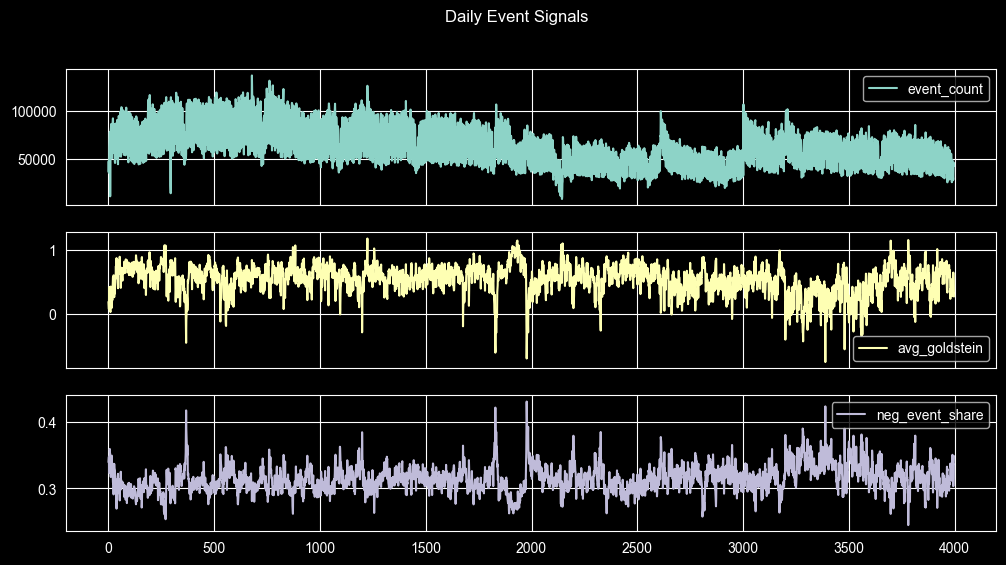

In [32]:
events_daily[["event_count", "avg_goldstein", "neg_event_share"]].plot(
    subplots=True, figsize=(12,6), title="Daily Event Signals"
)

events_daily.describe()

In [33]:
import pandas as pd
import numpy as np

events_daily = events_daily.sort_values("date").reset_index(drop=True)

events_daily[["event_count", "avg_goldstein", "neg_event_share"]].describe()

,event_count,avg_goldstein,neg_event_share
count,3998.000000,3998.000000,3998.000000
mean,67907.211856,0.544304,0.314658
std,22560.253814,0.220742,0.019470
min,7655.000000,-0.765472,0.245041
25%,51212.500000,0.427989,0.302517
50%,65836.000000,0.574409,0.312896
75%,85925.000000,0.689315,0.325970
max,137455.000000,1.185507,0.430041


In [34]:
WINDOW = 30

events_daily["event_count_ma"] = (
    events_daily["event_count"]
    .rolling(WINDOW, min_periods=10)
    .mean()
)

events_daily["goldstein_ma"] = (
    events_daily["avg_goldstein"]
    .rolling(WINDOW, min_periods=10)
    .mean()
)

events_daily["neg_share_ma"] = (
    events_daily["neg_event_share"]
    .rolling(WINDOW, min_periods=10)
    .mean()
)

In [35]:
events_daily["event_count_surprise"] = (
    events_daily["event_count"] - events_daily["event_count_ma"]
)

events_daily["goldstein_surprise"] = (
    events_daily["avg_goldstein"] - events_daily["goldstein_ma"]
)

events_daily["neg_share_surprise"] = (
    events_daily["neg_event_share"] - events_daily["neg_share_ma"]
)

In [36]:
def rolling_z(series, window=90):
    mu = series.rolling(window, min_periods=30).mean()
    sigma = series.rolling(window, min_periods=30).std()
    return (series - mu) / sigma

events_daily["event_count_z"] = rolling_z(events_daily["event_count"])
events_daily["neg_share_z"]   = rolling_z(events_daily["neg_event_share"])
events_daily["goldstein_z"]   = rolling_z(events_daily["avg_goldstein"])

In [38]:
events_daily["neg_share_delta"] = events_daily["neg_event_share"].diff()
events_daily["neg_share_accel"] = events_daily["neg_share_delta"].diff()

In [39]:
events_daily["EVENT_STRESS_INDEX"] = (
    events_daily["event_count_z"] *
    events_daily["neg_share_z"] *
    (-events_daily["goldstein_surprise"])
)

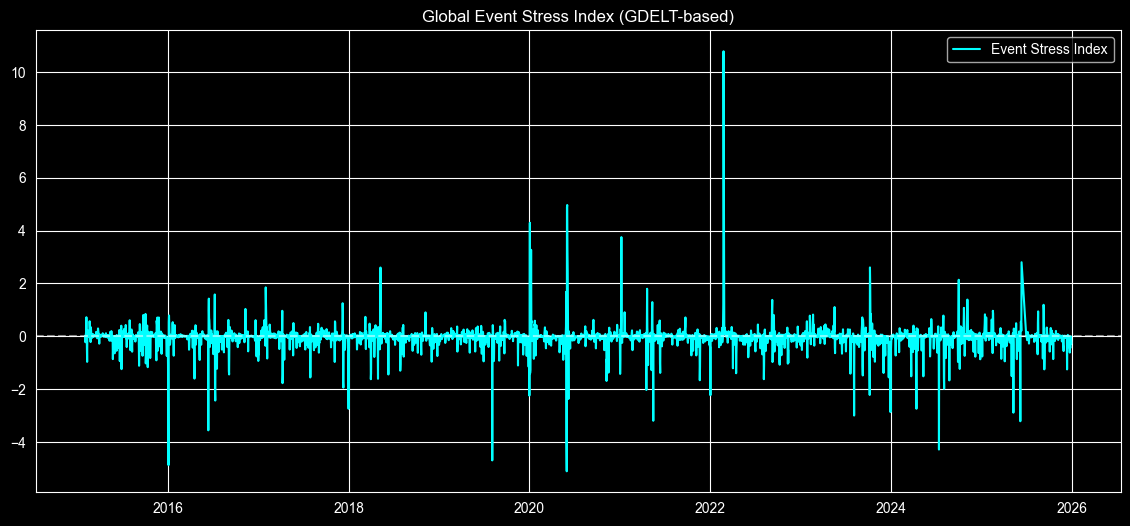

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(events_daily["date"], events_daily["EVENT_STRESS_INDEX"], label="Event Stress Index", color="cyan")
plt.axhline(0, color="white", linestyle="--", alpha=0.5)
plt.title("Global Event Stress Index (GDELT-based)")
plt.legend()
plt.show()